In [1]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe

keras = tf.keras
tf.enable_eager_execution()

In [2]:
from neural_ode import NeuralODE

In [3]:
# Load the pre-canned noisy data of the spiral.
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 500
nsample = 100
orig_trajs = tf.cast(np.loadtxt("latent_ode_data/orig_trajs.csv", delimiter=",").reshape((nspiral, ntotal, 2), order="F"), dtype=tf.float32)
samp_trajs = tf.cast(np.loadtxt("latent_ode_data/samp_trajs.csv", delimiter=",").reshape((nspiral, nsample, 2), order="F"), dtype=tf.float32)
# orig_trajs = np.loadtxt("latent_ode_data/orig_trajs.csv", delimiter=",").reshape((nspiral, ntotal, 2), order="F")
# samp_trajs = np.loadtxt("latent_ode_data/samp_trajs.csv", delimiter=",").reshape((nspiral, nsample, 2), order="F")
orig_ts = np.loadtxt("latent_ode_data/orig_ts.csv", delimiter=",")
samp_ts = tf.cast(np.loadtxt("latent_ode_data/samp_ts.csv", delimiter=","), dtype=tf.float32)

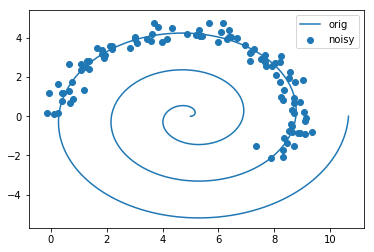

In [4]:
plt.figure()
plt.plot(orig_trajs[407, :, 0], orig_trajs[407, :, 1], label='orig')
plt.scatter(samp_trajs[407, :, 0], samp_trajs[407, :, 1], label='noisy')
plt.legend()
plt.show()

In [5]:
# simple network which is used to learn trajectory
class ODEModel(tf.keras.Model):
    def __init__(self, latent_dim=4, nhidden=20):
        super(ODEModel, self).__init__()
        self.elu = keras.layers.ELU()
        self.linear1 = keras.layers.Dense(nhidden)
        self.linear2 = keras.layers.Dense(nhidden)
        self.linear3 = keras.layers.Dense(latent_dim)

    def call(self, inputs, **kwargs):
        t, y = inputs
        out = self.linear1(y)
        out = self.elu(out)
        out = self.linear2(out)
        out = self.elu(out)
        out = self.linear3(out)
        return out

# Encoder / Recognition RNN
class RecognitionRNN(tf.keras.Model):

    def __init__(self, latent_dim=4, nhidden=25):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.i2h = keras.layers.Dense(nhidden, activation="tanh")
        self.h2o = keras.layers.Dense(latent_dim * 2)

    def call(self, inputs, **kwargs):
        h = self.i2h(inputs)
        out = self.h2o(h)
        return out, h
    
    def initHidden(self):
        return tf.zeros([1000, self.nhidden], dtype=tf.float32)

# Decoder
class Decoder(tf.keras.Model):
    def __init__(self, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = keras.layers.ReLU()
        self.fc1 = keras.layers.Dense(nhidden)
        self.fc2 = keras.layers.Dense(obs_dim)

    def call(self, inputs, **kwargs):
        out = self.fc1(inputs)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = ODEModel()
neural_ode = NeuralODE(model, t=samp_ts)
rec = RecognitionRNN()
dec = Decoder()
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)

In [6]:
def log_normal_pdf(x, mean, logvar):
    const = tf.cast(np.array([2. * np.pi]), dtype=tf.float32)
    const = tf.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / tf.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = tf.exp(lv1)
    v2 = tf.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

def compute_gradients_and_update(samp_trajs, samp_ts):
    """Variation Autoencoder (VAE) which run backwards in time through the given sample trajectories
       to make an intial predicition about z0.  NeuralODE then does a forward in time pass to get z1,..,zN.
       The decoder then transforms the latent zi's to sample space xi's. Loss is calculated then backpropagated.
    """
    
    with tf.GradientTape(persistent=True) as tape:
        
        # Backward in time
        h = rec.initHidden()
        for t in reversed(range(samp_trajs.shape[1])):
            obs = samp_trajs[:, t, :]
            out, h = rec(tf.concat([obs, h], 1))
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
        epsilon = tf.random.normal(qz0_mean.shape)
        z0 = epsilon * tf.exp(.5 * qz0_logvar) + qz0_mean
        
        # Forward prediction of the latent state using the NeuralODE
        outputs, states = neural_ode.forward(z0, return_states="tf")
#         print(outputs.shape)
#         print(tf.concat(states, 1).shape)
        pred_z = tf.reshape(tf.concat(states, 1), [states[0].shape[0], len(states), states[0].shape[1]])
#         print(pred_z.shape)
#         for i in range(100):
#             if (not tf.reduce_all(tf.equal(pred_z[:, i, :], states[i])).numpy()):
#                 print("not Equal ({})".format(i))
#         return
        # Move from latent space to sample space
        pred_x = dec(pred_z)
        
#         print(pred_x.shape)
        
        # Calculate KL divergence and loss
        noise_std_ = tf.zeros(pred_x.shape) + noise_std
        noise_logvar = 2. * tf.log(noise_std_)
        logpx = tf.reduce_sum(tf.reduce_sum(log_normal_pdf(
            samp_trajs, pred_x, noise_logvar), 2), 1)
        pz0_mean = pz0_logvar = tf.zeros(z0.shape)
        analytic_kl = tf.reduce_sum(normal_kl(qz0_mean, qz0_logvar,
                                pz0_mean, pz0_logvar), -1)
        loss = tf.reduce_mean(-logpx + analytic_kl)
    
    # Update the models
    dLoss = tape.gradient(loss, outputs)
    h_start, dfdh0, dWeights = neural_ode.backward(outputs, dLoss)
    optimizer.apply_gradients(zip(dWeights, model.weights))
    
    dLoss_drec = tape.gradient(loss, rec.variables)
    optimizer.apply_gradients(zip(dLoss_drec, rec.weights))
    
    dLoss_ddec = tape.gradient(loss, dec.variables)
    optimizer.apply_gradients(zip(dLoss_ddec, dec.weights))
    
    del tape
    return loss

# Compile EAGER graph to static (this will be much faster)
# compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

In [7]:
runningAvg = None
momentum = 0.99
loss_history = []
niters = 1395
for step in range(niters+1):
    
    loss = compute_gradients_and_update(samp_trajs, samp_ts)    
    loss_history.append(loss.numpy())
    
    runningAvg = loss if runningAvg is None else (runningAvg * momentum + loss * (1 - momentum))
    print("Iteration: {}, Loss: {}, running average elbo: {}".format(step, loss, -runningAvg))
#     if step % 500 == 0:        
#         yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")        
#         plot_spiral([true_y, np.concatenate(states_history_model)])        
#         plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Iteration: 0, Loss: 20453.896484375, running average elbo: -20453.896484375
Iteration: 1, Loss: 18172.603515625, running average elbo: -20431.083984375
Iteration: 2, Loss: 16579.62890625, running average elbo: -20392.5703125
Iteration: 3, Loss: 14713.0341796875, running average elbo: -20335.775390625
Iteration: 4, Loss: 12453.4287109375, running average elbo: -20256.953125
Iteration: 5, Loss: 10438.0615234375, running average elbo: -20158.763671875
Iteration: 6, Loss: 9053.97265625, running average elbo: -20047.71484375
Iteration: 7, Loss: 8078.265625, running average elbo: -19928.021484375
Iteration: 8, Loss: 7481.15185546875, running average elbo: -19803.552734375
Iteration: 9, Loss: 6816.35595703125, running average elbo: -19673.681640625
Iteration: 10, Loss: 6378.7265625, running average elbo: -19540.732421875
Iteration: 11, Loss: 6194.4482421875, running average 

Iteration: 99, Loss: 2008.2352294921875, running average elbo: -10301.2802734375
Iteration: 100, Loss: 2050.508056640625, running average elbo: -10218.7724609375
Iteration: 101, Loss: 2135.15771484375, running average elbo: -10137.9365234375
Iteration: 102, Loss: 2110.744384765625, running average elbo: -10057.6650390625
Iteration: 103, Loss: 1948.7205810546875, running average elbo: -9976.576171875
Iteration: 104, Loss: 2078.876708984375, running average elbo: -9897.599609375
Iteration: 105, Loss: 1923.166748046875, running average elbo: -9817.85546875
Iteration: 106, Loss: 2022.6719970703125, running average elbo: -9739.9033203125
Iteration: 107, Loss: 1962.0235595703125, running average elbo: -9662.1240234375
Iteration: 108, Loss: 1954.75048828125, running average elbo: -9585.05078125
Iteration: 109, Loss: 1903.8294677734375, running average elbo: -9508.23828125
Iteration: 110, Loss: 1905.6285400390625, running average elbo: -9432.212890625
Iteration: 111, Loss: 1885.762451171875, r

Iteration: 202, Loss: 1092.6875, running average elbo: -4667.37841796875
Iteration: 203, Loss: 1087.137451171875, running average elbo: -4631.576171875
Iteration: 204, Loss: 975.5923461914062, running average elbo: -4595.01611328125
Iteration: 205, Loss: 1009.1722412109375, running average elbo: -4559.15771484375
Iteration: 206, Loss: 1025.1419677734375, running average elbo: -4523.81787109375
Iteration: 207, Loss: 1055.8082275390625, running average elbo: -4489.1376953125
Iteration: 208, Loss: 1025.574951171875, running average elbo: -4454.50244140625
Iteration: 209, Loss: 1042.5826416015625, running average elbo: -4420.38330078125
Iteration: 210, Loss: 978.067138671875, running average elbo: -4385.96044921875
Iteration: 211, Loss: 965.08056640625, running average elbo: -4351.751953125
Iteration: 212, Loss: 1034.767822265625, running average elbo: -4318.58203125
Iteration: 213, Loss: 1018.3462524414062, running average elbo: -4285.580078125
Iteration: 214, Loss: 987.1912841796875, run

Iteration: 304, Loss: 730.2133178710938, running average elbo: -2389.296875
Iteration: 305, Loss: 759.1660766601562, running average elbo: -2372.995361328125
Iteration: 306, Loss: 744.329833984375, running average elbo: -2356.708740234375
Iteration: 307, Loss: 715.8958740234375, running average elbo: -2340.300537109375
Iteration: 308, Loss: 736.7698974609375, running average elbo: -2324.26513671875
Iteration: 309, Loss: 755.1797485351562, running average elbo: -2308.57421875
Iteration: 310, Loss: 760.4645385742188, running average elbo: -2293.09326171875
Iteration: 311, Loss: 765.8658447265625, running average elbo: -2277.821044921875
Iteration: 312, Loss: 735.4044799804688, running average elbo: -2262.39697265625
Iteration: 313, Loss: 724.3623657226562, running average elbo: -2247.0166015625
Iteration: 314, Loss: 721.9452514648438, running average elbo: -2231.765869140625
Iteration: 315, Loss: 729.5244750976562, running average elbo: -2216.743408203125
Iteration: 316, Loss: 718.903503

Iteration: 405, Loss: 394.57275390625, running average elbo: -1181.861083984375
Iteration: 406, Loss: 360.75048828125, running average elbo: -1173.6500244140625
Iteration: 407, Loss: 324.71728515625, running average elbo: -1165.1607666015625
Iteration: 408, Loss: 326.05792236328125, running average elbo: -1156.769775390625
Iteration: 409, Loss: 338.1510009765625, running average elbo: -1148.5836181640625
Iteration: 410, Loss: 359.1460876464844, running average elbo: -1140.689208984375
Iteration: 411, Loss: 373.7081298828125, running average elbo: -1133.0194091796875
Iteration: 412, Loss: 332.486572265625, running average elbo: -1125.0140380859375
Iteration: 413, Loss: 374.5949401855469, running average elbo: -1117.5098876953125
Iteration: 414, Loss: 475.7188720703125, running average elbo: -1111.092041015625
Iteration: 415, Loss: 400.4853820800781, running average elbo: -1103.9859619140625
Iteration: 416, Loss: 544.2857666015625, running average elbo: -1098.3890380859375
Iteration: 417

Iteration: 505, Loss: 197.30313110351562, running average elbo: -629.4922485351562
Iteration: 506, Loss: 197.96975708007812, running average elbo: -625.177001953125
Iteration: 507, Loss: 196.44552612304688, running average elbo: -620.8897094726562
Iteration: 508, Loss: 195.20462036132812, running average elbo: -616.6328735351562
Iteration: 509, Loss: 196.4641876220703, running average elbo: -612.4312133789062
Iteration: 510, Loss: 196.7870635986328, running average elbo: -608.2747802734375
Iteration: 511, Loss: 194.866943359375, running average elbo: -604.1406860351562
Iteration: 512, Loss: 194.47637939453125, running average elbo: -600.0440673828125
Iteration: 513, Loss: 194.7376251220703, running average elbo: -595.9910278320312
Iteration: 514, Loss: 193.61849975585938, running average elbo: -591.96728515625
Iteration: 515, Loss: 192.76516723632812, running average elbo: -587.9752807617188
Iteration: 516, Loss: 191.94540405273438, running average elbo: -584.0149536132812
Iteration: 5

Iteration: 605, Loss: 165.0226287841797, running average elbo: -342.2931213378906
Iteration: 606, Loss: 164.36546325683594, running average elbo: -340.5138244628906
Iteration: 607, Loss: 164.97149658203125, running average elbo: -338.7584228515625
Iteration: 608, Loss: 163.2282257080078, running average elbo: -337.0031433105469
Iteration: 609, Loss: 163.49276733398438, running average elbo: -335.2680358886719
Iteration: 610, Loss: 162.42269897460938, running average elbo: -333.5395812988281
Iteration: 611, Loss: 163.2440643310547, running average elbo: -331.8366394042969
Iteration: 612, Loss: 164.39540100097656, running average elbo: -330.1622314453125
Iteration: 613, Loss: 162.06365966796875, running average elbo: -328.48126220703125
Iteration: 614, Loss: 162.40213012695312, running average elbo: -326.8204650878906
Iteration: 615, Loss: 162.5950164794922, running average elbo: -325.17822265625
Iteration: 616, Loss: 161.8248748779297, running average elbo: -323.5447082519531
Iteration:

Iteration: 704, Loss: 152.0966339111328, running average elbo: -224.94375610351562
Iteration: 705, Loss: 149.99961853027344, running average elbo: -224.19432067871094
Iteration: 706, Loss: 148.1426544189453, running average elbo: -223.43380737304688
Iteration: 707, Loss: 145.88967895507812, running average elbo: -222.6583709716797
Iteration: 708, Loss: 146.30699157714844, running average elbo: -221.89486694335938
Iteration: 709, Loss: 145.74891662597656, running average elbo: -221.13340759277344
Iteration: 710, Loss: 146.2139434814453, running average elbo: -220.38421630859375
Iteration: 711, Loss: 146.11611938476562, running average elbo: -219.64154052734375
Iteration: 712, Loss: 147.28858947753906, running average elbo: -218.9180145263672
Iteration: 713, Loss: 146.80950927734375, running average elbo: -218.19692993164062
Iteration: 714, Loss: 146.0430450439453, running average elbo: -217.47540283203125
Iteration: 715, Loss: 144.697021484375, running average elbo: -216.74761962890625


Iteration: 803, Loss: 197.1900634765625, running average elbo: -187.77865600585938
Iteration: 804, Loss: 174.2152862548828, running average elbo: -187.6430206298828
Iteration: 805, Loss: 177.83290100097656, running average elbo: -187.544921875
Iteration: 806, Loss: 177.11920166015625, running average elbo: -187.440673828125
Iteration: 807, Loss: 187.898193359375, running average elbo: -187.44525146484375
Iteration: 808, Loss: 159.74917602539062, running average elbo: -187.1682891845703
Iteration: 809, Loss: 213.12049865722656, running average elbo: -187.42782592773438
Iteration: 810, Loss: 175.46493530273438, running average elbo: -187.30819702148438
Iteration: 811, Loss: 197.10275268554688, running average elbo: -187.40614318847656
Iteration: 812, Loss: 195.64793395996094, running average elbo: -187.4885711669922
Iteration: 813, Loss: 198.32205200195312, running average elbo: -187.59690856933594
Iteration: 814, Loss: 171.62939453125, running average elbo: -187.43724060058594
Iteration

Iteration: 903, Loss: 548.92919921875, running average elbo: -373.409423828125
Iteration: 904, Loss: 556.7247314453125, running average elbo: -375.2425842285156
Iteration: 905, Loss: 578.744873046875, running average elbo: -377.2776184082031
Iteration: 906, Loss: 625.1893920898438, running average elbo: -379.7567443847656
Iteration: 907, Loss: 568.0974731445312, running average elbo: -381.64013671875
Iteration: 908, Loss: 538.6737060546875, running average elbo: -383.2104797363281
Iteration: 909, Loss: 517.1455688476562, running average elbo: -384.5498352050781
Iteration: 910, Loss: 518.0814208984375, running average elbo: -385.8851623535156
Iteration: 911, Loss: 526.4854736328125, running average elbo: -387.2911682128906
Iteration: 912, Loss: 535.755126953125, running average elbo: -388.77581787109375
Iteration: 913, Loss: 524.2623291015625, running average elbo: -390.13067626953125
Iteration: 914, Loss: 512.0689086914062, running average elbo: -391.3500671386719
Iteration: 915, Loss:

Iteration: 1004, Loss: 262.2915954589844, running average elbo: -425.8587646484375
Iteration: 1005, Loss: 245.43768310546875, running average elbo: -424.0545654296875
Iteration: 1006, Loss: 264.8268127441406, running average elbo: -422.4622802734375
Iteration: 1007, Loss: 248.5911407470703, running average elbo: -420.72357177734375
Iteration: 1008, Loss: 251.5757293701172, running average elbo: -419.0320739746094
Iteration: 1009, Loss: 245.93045043945312, running average elbo: -417.3010559082031
Iteration: 1010, Loss: 232.31642150878906, running average elbo: -415.4512023925781
Iteration: 1011, Loss: 232.93890380859375, running average elbo: -413.6260681152344
Iteration: 1012, Loss: 235.05709838867188, running average elbo: -411.84039306640625
Iteration: 1013, Loss: 234.72337341308594, running average elbo: -410.0692138671875
Iteration: 1014, Loss: 237.44393920898438, running average elbo: -408.3429870605469
Iteration: 1015, Loss: 231.6840057373047, running average elbo: -406.576385498

Iteration: 1103, Loss: 369.5279235839844, running average elbo: -321.28424072265625
Iteration: 1104, Loss: 316.16778564453125, running average elbo: -321.23309326171875
Iteration: 1105, Loss: 345.1992492675781, running average elbo: -321.4727478027344
Iteration: 1106, Loss: 373.1341247558594, running average elbo: -321.9893798828125
Iteration: 1107, Loss: 370.34423828125, running average elbo: -322.4729309082031
Iteration: 1108, Loss: 307.54833984375, running average elbo: -322.32366943359375
Iteration: 1109, Loss: 302.5639343261719, running average elbo: -322.1260681152344
Iteration: 1110, Loss: 399.70782470703125, running average elbo: -322.9018859863281
Iteration: 1111, Loss: 498.08111572265625, running average elbo: -324.6536865234375
Iteration: 1112, Loss: 549.5157470703125, running average elbo: -326.9023132324219
Iteration: 1113, Loss: 428.38482666015625, running average elbo: -327.9171447753906
Iteration: 1114, Loss: 396.21905517578125, running average elbo: -328.60015869140625

Iteration: 1202, Loss: 249.89378356933594, running average elbo: -324.56671142578125
Iteration: 1203, Loss: 246.98455810546875, running average elbo: -323.7908935546875
Iteration: 1204, Loss: 246.47616577148438, running average elbo: -323.0177307128906
Iteration: 1205, Loss: 252.8504180908203, running average elbo: -322.3160705566406
Iteration: 1206, Loss: 263.1680603027344, running average elbo: -321.724609375
Iteration: 1207, Loss: 264.92919921875, running average elbo: -321.1566467285156
Iteration: 1208, Loss: 259.7781677246094, running average elbo: -320.5428466796875
Iteration: 1209, Loss: 253.4205780029297, running average elbo: -319.87164306640625
Iteration: 1210, Loss: 249.7723388671875, running average elbo: -319.170654296875
Iteration: 1211, Loss: 248.8461151123047, running average elbo: -318.4674072265625
Iteration: 1212, Loss: 253.81246948242188, running average elbo: -317.82086181640625
Iteration: 1213, Loss: 263.35418701171875, running average elbo: -317.2762145996094
Ite

Iteration: 1301, Loss: 1074.4403076171875, running average elbo: -469.1500549316406
Iteration: 1302, Loss: 1019.39306640625, running average elbo: -474.6524963378906
Iteration: 1303, Loss: 869.8328857421875, running average elbo: -478.60430908203125
Iteration: 1304, Loss: 679.1024780273438, running average elbo: -480.6092834472656
Iteration: 1305, Loss: 578.2855224609375, running average elbo: -481.5860595703125
Iteration: 1306, Loss: 610.2195434570312, running average elbo: -482.8724060058594
Iteration: 1307, Loss: 729.5202026367188, running average elbo: -485.3388977050781
Iteration: 1308, Loss: 866.8258666992188, running average elbo: -489.15374755859375
Iteration: 1309, Loss: 969.218994140625, running average elbo: -493.95440673828125
Iteration: 1310, Loss: 1000.8727416992188, running average elbo: -499.0235900878906
Iteration: 1311, Loss: 954.8018798828125, running average elbo: -503.58135986328125
Iteration: 1312, Loss: 808.0004272460938, running average elbo: -506.6255798339844


(1, 4)
2000
(4,)
(2000, 2)


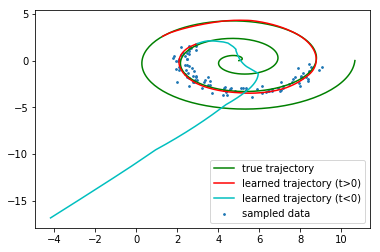

In [8]:
# Test:
# Sample from trajectorys' approx. posterior
h = rec.initHidden()
for t in reversed(range(samp_trajs.shape[1])):
    obs = samp_trajs[:, t, :]
    out, h = rec(tf.concat([obs, h], 1))
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = tf.random.normal(qz0_mean.shape)
z0 = epsilon * tf.exp(.5 * qz0_logvar) + qz0_mean

# take first trajectory for visualization
print(tf.reshape(z0[0], [1, 4]).shape)
z0 = tf.reshape(z0[0], [1, 4])

ts_pos = np.linspace(0., 2. * np.pi, num=2000)
ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
ts_pos = tf.cast(ts_pos, dtype=tf.float32)
ts_neg = tf.cast(ts_neg, dtype=tf.float32)

neural_ode_pos = NeuralODE(model, t=ts_pos)
outputs, zs_pos = neural_ode_pos.forward(z0, return_states="tf")
neural_ode_neg = NeuralODE(model, t=ts_neg)
outputs, zs_neg = neural_ode_neg.forward(z0, return_states="tf")

zs_pos = tf.reshape(tf.concat(zs_pos, 1), [len(zs_pos), zs_pos[0].shape[1]])
zs_neg = tf.reshape(tf.concat(zs_neg, 1), [len(zs_neg), zs_neg[0].shape[1]])

print(len(zs_pos))
print(zs_pos[0].shape)


xs_pos = dec(zs_pos)
xs_neg = tf.reverse(dec(zs_neg), [0])
print(xs_pos.shape)

xs_pos = xs_pos.numpy()
xs_neg = xs_neg.numpy()
orig_traj = orig_trajs[0].numpy()
samp_traj = samp_trajs[0].numpy()

plt.figure()
plt.plot(orig_traj[:, 0], orig_traj[:, 1], 'g', label='true trajectory')
plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r', label='learned trajectory (t>0)')
plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c', label='learned trajectory (t<0)')
plt.scatter(samp_traj[:, 0], samp_traj[:, 1], label='sampled data', s=3)
plt.legend()